In [15]:
# Кластеризація методом k-means.

# pip install yellowbrick
# conda install kneed

import warnings
import pickle
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [16]:
# 1. Завантажте набір даних Concrete.
with open('../datasets/mod_05_topic_10_various_data.pkl', 'rb') as fl:
    datasets = pickle.load(fl)

concrete = datasets['concrete']
concrete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cement               427 non-null    float64
 1   BlastFurnaceSlag     427 non-null    float64
 2   FlyAsh               427 non-null    float64
 3   Water                427 non-null    float64
 4   Superplasticizer     427 non-null    float64
 5   CoarseAggregate      427 non-null    float64
 6   FineAggregate        427 non-null    float64
 7   CompressiveStrength  427 non-null    float64
dtypes: float64(8)
memory usage: 26.8 KB


In [17]:
# 2. Використайте прийом підрахунку кількості для створення нової ознаки Components, 
    # яка вказуватиме на кількість задіяних складових у різних рецептурах бетону.
components = ['Cement',
              'BlastFurnaceSlag',
              'FlyAsh',
              'Water',
              'Superplasticizer',
              'CoarseAggregate',
              'FineAggregate']

concrete['Components'] = concrete[components].gt(0).sum(axis=1)    # .greater than 0 .sum(axis=1): підсумовує результат по рядках.

concrete[components + ['Components']].head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,102.0,153.0,0.0,192.0,0.0,887.0,942.0,5
1,108.3,162.4,0.0,203.5,0.0,938.2,849.0,5
2,116.0,173.0,0.0,192.0,0.0,909.8,891.9,5
3,122.6,183.9,0.0,203.5,0.0,958.2,800.1,5
4,132.0,206.5,160.9,178.9,5.5,866.9,735.6,7


In [18]:
# 3. Нормалізуйте набір даних за допомогою об’єкта StandardScaler з пакета sklearn для подальшої кластеризації.
X = StandardScaler().fit_transform(concrete)

In [19]:
# 4. Визначте оптимальну кількість кластерів за допомогою об'єкта KElbowVisualizer з пакета yellowbrick.
# 4a). розрахунок головних компонент
pca = PCA(random_state=42).fit(X)
pve = pca.explained_variance_ratio_

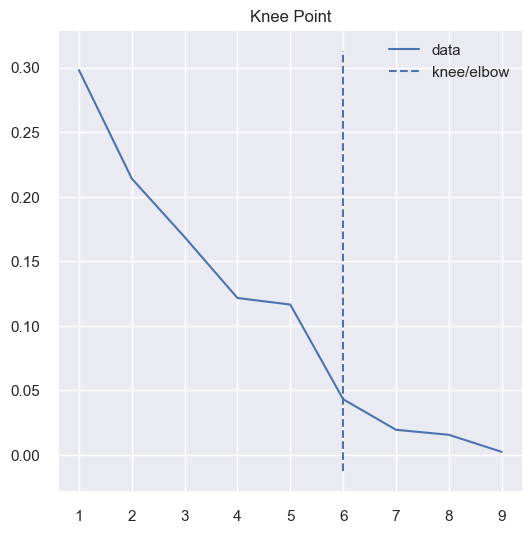

In [20]:
# 4b). Пошук оптимальноъ кількості головних компонетн за "правилом ліктя” на графіку дисперсії (змінності) даних
sns.set_theme()

kneedle = KneeLocator(
    x=range(1, len(pve) + 1),
    y=pve,
    curve='convex',
    direction='decreasing')

kneedle.plot_knee()

plt.show()
# Визначена візуально за “правилом ліктя” оптимальна кількість головних компонент дорівнює 6.
# Проте цікаво спробувати й 4, оскільки це выдповыдало б емпіричному правилу 1:10 

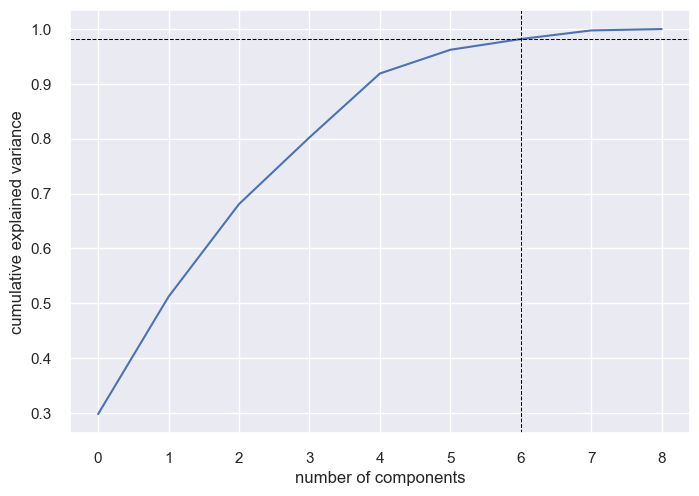

In [21]:
# 4c). Визначимо й візуалізуємо на графіку кумулятивну частку змінності даних, яку пояснюють 9 перших головних компонент:
n_components = kneedle.elbow

ax = sns.lineplot(np.cumsum(pve))

ax.axvline(x=n_components,
           c='black',
           linestyle='--',
           linewidth=0.75)

ax.axhline(y=np.cumsum(pve)[n_components],
           c='black',
           linestyle='--',
           linewidth=0.75)

ax.set(xlabel='number of components',
       ylabel='cumulative explained variance')

plt.show()
# Отже, після зменшення розмірності даних ми зберігаємо приблизно 97% “інформативності” вхідного. (дуже високий показник)
# У випадку 4 - 92%

In [22]:
# 4d). Зменшуємо розмірність даних за допомогою PCA:
X = pca.transform(X)[:, :n_components]
#  X = pca.transform(X)[:, :4]

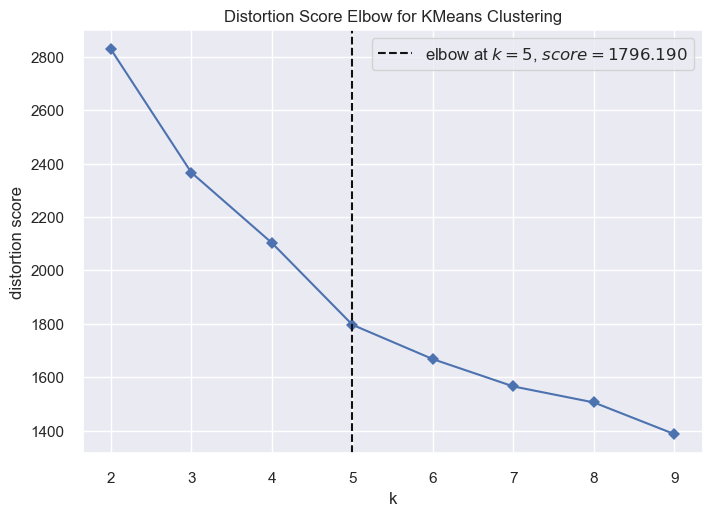

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
# 4e). Кластеризація набору даних. Визначення кількості кластерів за допомогою KMeans
model_kmn = KMeans(random_state=42)

visualizer = KElbowVisualizer(
    model_kmn,
    k=(2, 10),
    timings=False)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    visualizer.fit(X)

visualizer.show()
# Визначена оптимальна кількість кластерів для цього набору даних за “правилом ліктя” дорівнює 5.

In [24]:
# 5. Проведіть кластеризацію методом k-середніх і отримайте мітки для кількості кластерів, визначеної на попередньому кроці.
k_best = visualizer.elbow_value_
# k_best = 3
model_kmn = KMeans(n_clusters=k_best, random_state=42).fit(X)

labels_kmn = pd.Series(model_kmn.labels_, name='k-means')

C:\Users\user\miniconda3\envs\env_mlf\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


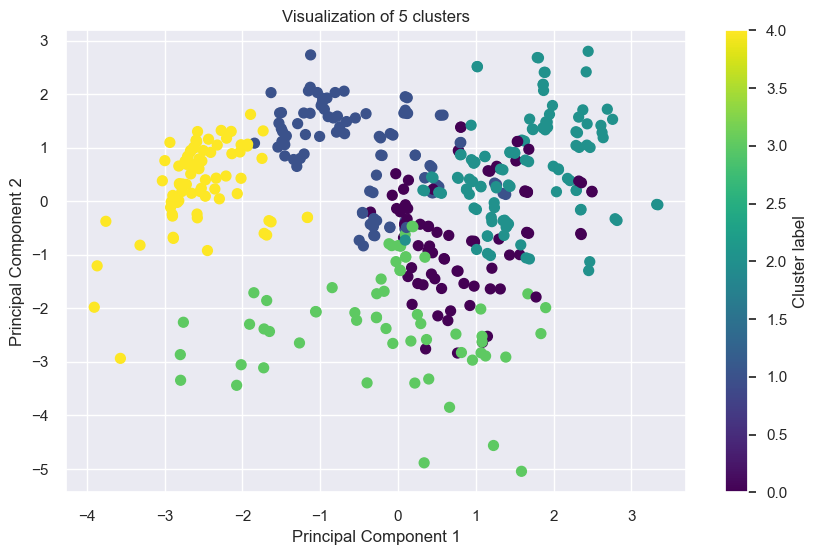

In [25]:
# Візуалізація 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmn, cmap='viridis', s=50)
plt.title(f'Visualization of {k_best} clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster label')
plt.show()

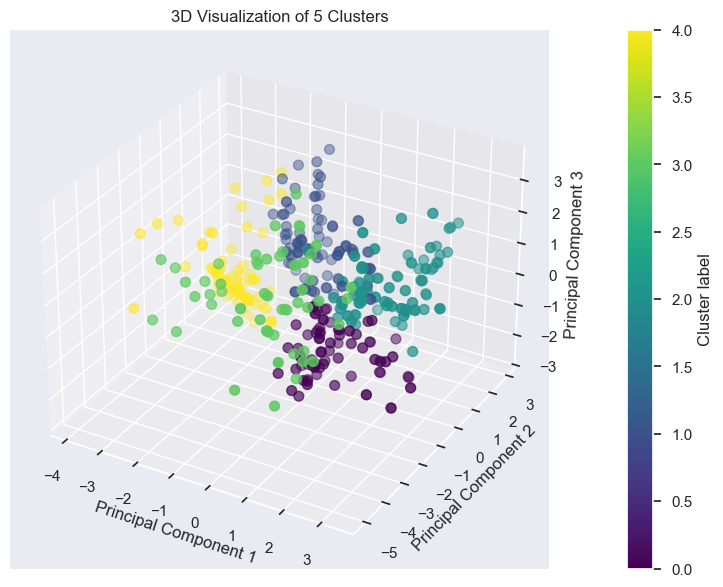

In [26]:
# Візуалізація 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
# X_pca = X # Візуалізація по першим головним компонентам

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                     c=labels_kmn, cmap='viridis', s=50)
# Заголовки та підписи осей
ax.set_title(f'3D Visualization of {k_best} Clusters')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
# Кольорова шкала
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster label')
plt.show()

In [27]:
# 6. Використайте оригінальний набір вхідних даних для розрахунку описової статистики кластерів («звіту»): 
    # розрахуйте медіани для кожної ознаки, включаючи підрахунок кількості компонент по кожному кластеру за допомогою методу groupby.
data = concrete.copy()
data['Cluster'] = labels_kmn

cluster_medians = data.groupby('Cluster').median()
print("Cluster medians:")
print(cluster_medians)

cluster_counts = data.groupby('Cluster').size().rename('Count')
print("Cluster counts:")
print(cluster_counts)

report = pd.concat([cluster_medians, cluster_counts], axis=1)
report

Cluster medians:
         Cement  BlastFurnaceSlag  ...  CompressiveStrength  Components
Cluster                            ...                                 
0        212.05              0.00  ...                39.42         6.0
1        188.10            183.00  ...                37.43         6.0
2        172.70            120.75  ...                32.62         7.0
3        387.00            102.05  ...                61.66         6.0
4        339.00              0.00  ...                33.70         4.0

[5 rows x 9 columns]
Cluster counts:
Cluster
0     82
1     90
2    114
3     60
4     81
Name: Count, dtype: int64


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,CompressiveStrength,Components,Count
Cluster,,,,,,,,,,
0,212.05,0.00,124.95,170.10,9.8,1002.9,797.55,39.42,6.0,82
1,188.10,183.00,0.00,185.75,3.0,973.0,754.65,37.43,6.0,90
2,172.70,120.75,114.40,193.80,8.5,880.0,742.70,32.62,7.0,114
3,387.00,102.05,0.00,162.00,9.8,918.5,786.25,61.66,6.0,60
4,339.00,0.00,0.00,189.00,0.0,1040.0,775.00,33.70,4.0,81


In [28]:
# 7. Додайте до звіту кількість об'єктів (рецептур) у кожному з кластерів.
report.columns = [f'Median {col}' for col in report.columns[:-1]] + ['Count']
report.head()

,Median Cement,Median BlastFurnaceSlag,Median FlyAsh,Median Water,Median Superplasticizer,Median CoarseAggregate,Median FineAggregate,Median CompressiveStrength,Median Components,Count
Cluster,,,,,,,,,,
0,212.05,0.00,124.95,170.10,9.8,1002.9,797.55,39.42,6.0,82
1,188.10,183.00,0.00,185.75,3.0,973.0,754.65,37.43,6.0,90
2,172.70,120.75,114.40,193.80,8.5,880.0,742.70,32.62,7.0,114
3,387.00,102.05,0.00,162.00,9.8,918.5,786.25,61.66,6.0,60
4,339.00,0.00,0.00,189.00,0.0,1040.0,775.00,33.70,4.0,81


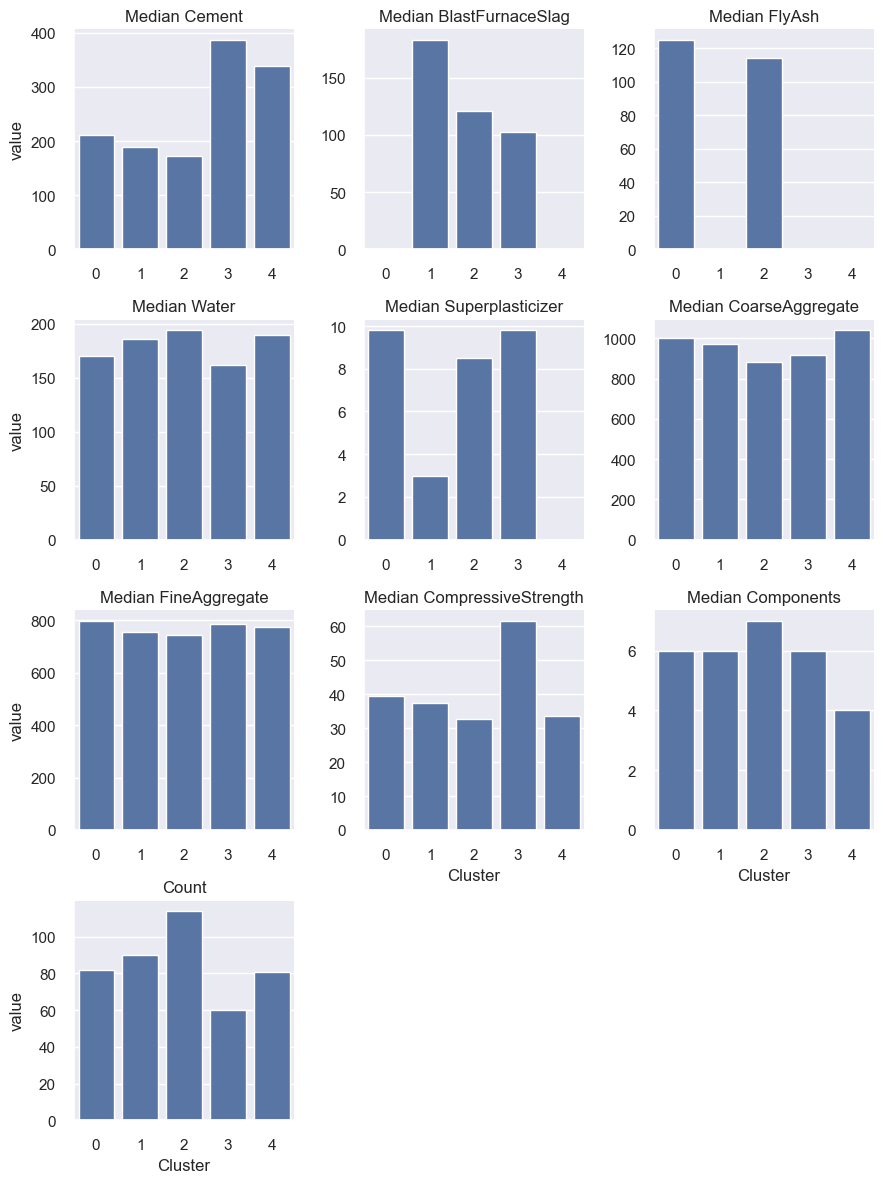

In [29]:
report_reset = report.reset_index()
melted = report_reset.melt(id_vars=['Cluster'])

g = sns.FacetGrid(melted, 
                  col='variable', 
                  col_wrap=3, 
                  sharex=False, 
                  sharey=False)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    g.map(sns.barplot, 'Cluster', 'value')
# Заголовки та підписи осей
g.set_titles(col_template='{col_name}')
g.tight_layout()
plt.show()

# Аналіз:

### Кількість головних компанентів
Спроба без зменшення розмірності датасету а також спроба зменшення розмірності до 4 головних компонент замість 6 (що теж візуально виглядало допустимим за "правилом ліктя") помітних змін не привнесло. В будь якому випадку k-means визначав найбільш опримальним 5 кластерів

### Поділ на 5 кластерів
1. Візуально здається, що кластеризація відбулася на сама вдала - чітких кордонів між кластерами не спостерігається, кластери перемішуються і зачіпають простір інших. Це могло говорити про занадто високу кількість кластерів, проте, як побачимо далі, кластеризація має свою логіку.

2. На діарамах рзподілу компонентів по по кластерам добре видно, що пиміс шлаку відсутній у цементі кластерів 0 та 4, А зола відсутня у кластрах 1, 3 та 4. Крім того Суперпластифікатор відсутній у кластарі 4. І оскільки решта ознак більш-менг рівномірні, схоже, це основна логіка розділення на кластари.

3. Так якщо:
    * цемент не мамє шлаку, але має золу = це кластер 0
    * не має золи, шлаку та суперпластифікатора = кластер 4 
    * має шлак і золу  = кластер 2
    * а кластери 1 та 3, які мають шлак та не мають золи, треба шукати у інших ознаках, таких як:
        - кількість цементу, в 1 біля 200, а в 3 - біля 400 
        - міцність на стиск, в 1 до 40, а в 3 - під 60
        - тобто решта рецептур ділиться на 2 кластери по міцності (більше цементу дає більше міцності, менше цементу - менше міцності)

4. Тому і бачимо, що найменге компонентів у кластері 4 (4 компонета -  не має золи, шлаку та суперпластифікатора), найбільше у кластері 2 (7 компонентів - має шлак і золу і, схоже, всі можливі компоненти).

### Поділ на 3 кластери
1. Варто сказати також про можливість кластеризації на 3 кластери (виявлено хляхом спроб).
    * Достатьо чіткі кордони,
    * на 3D візуалізаціє видно що компонети шикуються в рядочки, немов би рецептури формувались штучно (наприклад, додаємо компоненту 120 грам, в наступний 130, 140, 150 і так далі, наким чином отримуємо серію рецептів)
    * 3 кластери чітко розподіляються на:
        - кластер 0: містить, але не золу;
        - кластер 1: Ні шлаку ні золи (і суперкласівкатора тут нема);
        - кластер 2: І шлак і золу (до речі, вполовині менше цементу тоді треба)

# Висновки:
* Різна кількість головних компонент і навіть відмова від зменшення ролзмірності в нашом випадку мало впливали на кластеризацію.
* Визначена оптимальна кількість кластерів за допомогою KMeans (5 кластрів) для цього набору достатньо вдала і може бути логічно обгрунтована.
* Можлива менша кількість кластерів (3 кластари), яка дещо краще кластирезується, на наш погляд, і може бути запропонована при потребі меншої кількості кластрів.